In [1]:
import os
import pandas as pd
import numpy as np
import gower
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 

import matplotlib.style
import matplotlib as mpl

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['figure.facecolor'] = 'white'

# __A guide to clustering large datasets with mixed data-types__


*Pre-note If you are an early stage or aspiring data analyst, data scientist, or just love working with numbers clustering is a fantastic topic to start with. In fact I actively steer early career and junior data scientist toward this topic early on in their training and continued professional development cycle - sorry guys but its for your own good.*

Learning how to apply and perform accurate clustering analysis takes you though many of the core principles of data analysis, mathematics, machine learning, and computational science. From learning about data types and geometry, confusion matrix, to applying iterative aglorithms and efficient computation on big data. These foundational concepts crop up in most other areas of data science and machine learning. For instance, cluster distance matrices underpin and, mathematically, are near identical to graph data structures used in deep learning graph neural networks at the cutting edge of artificial intelligence research. So if you are just starting out then dont be put of and read on regardless of your level. We all have to start somewhere and this is a very good place!

# __1. Introduction__
Cluster analysis is the task of grouping objects within a population in such a way that objects in the same group or cluster are more similar to one another than to those in other clusters. Clustering is a form of unsupervised learning as the number, size and distribution of clusters is unknown a priori. Clustering can be applied to a variety of different problems and domains including: customer segmentation for retail sales and marketing, identifying higher or lower risk groups within insurance portfolios, to finding storm systems on Jupyter, and even identifying galaxies far far away.

Many real world datasets include combinations of numerical, ordinal (e.g. small, medium, large), and nominal (e.g. France, China, India) data features. However, many popular clustering algorithms and tutorials such as K-means are suitable for numerical data types only. This article is written on the assumption that these methods are familiar - but otherwise Sklearn provides an excellent review of these methods here for a quick refresher.

# __1.1 Aim:__
To evaluate methods to cluster datasets containing a variety of dataype's.

# __1.2 Objectives:__

1. To research and review clustering techniques for mixed datatype datasets.

2. To research and review feature encoding and engineering strategies.
  
3. To apply and review clustering methods on a test dataset.


# __2 Case Study: Bank Marketing__

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

## __Attribute Information:__

## Bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
- default: has credit in default? (categorical: 'no','yes','unknown')
- housing: has housing loan? (categorical: 'no','yes','unknown')
- loan: has personal loan? (categorical: 'no','yes','unknown')
## Related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day: last contact day of the month (numerical: '1','2',....,'27','31')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
## Other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


In [4]:
# load data
DATA_PATH = os.path.join(os.getcwd(),'..')
raw = pd.read_csv(os.path.join(DATA_PATH,'bank_marketing.csv'),low_memory=False,)

# convert numerical-object to numericals
#for col in ['time','latitude','longitude','depth', 'mag','magType', 'nst', 'gap', 'dmin', 'rms', 'net', 'id', 'updated', 'place', 'type', 'horizontal', 'depthError', 'magNst', 'status', 'locationSource', 'magSource']:
#    raw[col] = raw[col].replace('[^.0-9]', '', regex=True,).astype(float).fillna(0.0)

# clean textual classes
#for col in raw.select_dtypes(include='object').columns:
#        raw[col] = raw[col].str.upper().replace('Z_','',regex=True).replace('[^A-Z]','',regex=True)
        
data_types = {f:t for f,t in zip(raw.columns,raw.dtypes)}

raw[:5]

,Unnamed: 0,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,0,41,services,married,unknown,no,88,yes,no,cellular,11,may,105,1,336,2,failure,no
1,1,56,technician,married,secondary,no,1938,no,yes,cellular,26,feb,229,1,192,4,success,yes
2,2,30,services,single,secondary,no,245,no,yes,cellular,8,jul,187,2,-1,0,unknown,no
3,3,34,management,single,tertiary,no,1396,yes,no,cellular,17,jul,630,1,-1,0,unknown,no
4,4,29,technician,single,secondary,no,-13,yes,no,cellular,14,may,512,3,-1,0,unknown,no


# __3. Method__
## __3.1 Data pre-processing__
Apply processing to correct and handle erroneous values, and rename fields and values to make the data easier to work with. Including:

- remove or fill null values
- drop irrelevant columns
- shorten categorical value names

In [5]:
# copy df
df = raw.copy()

# drop ID and Birth
df.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

# remove all nan values
for col in ['age','balance','day', 'duration', 'pdays']:
    df[col].fillna(df[col].mean(),inplace=True)
if df.isnull().sum().sum() == 0: print('No NaNs')
    
df["loan"].replace({"yes":1, "no":0}, inplace = True)
df["housing"].replace({"yes":1, "no":0}, inplace = True)
df["deposit"].replace({"no":0, "yes":1}, inplace = True)
df["default"].replace({"yes":1, "no":0}, inplace = True)


data_meta = pd.DataFrame(df.nunique(),columns=['num'],index=None).sort_values('num').reset_index()
data_meta.columns = ['name','num']
data_meta['type'] = 'numerical'

# exclude known numericals
data_meta.loc[(data_meta['num']<=500) & (~data_meta['name'].isin(['loan','deposit','housing', 'default','pdays','age','day', 'duration', 'campaign'])),'type']='categorical'
data_meta.loc[data_meta['name'].isin(['loan', 'housing', 'deposit']),'type']='claim'

categorical_features = list(data_meta.loc[data_meta['type']=='categorical','name'])
numerical_features = list(data_meta.loc[data_meta['type']=='numerical','name'])

df['job'] = df['job'].map({'admin.':'Ad',         
'blue-collar':'Blu',    
'entrepreneur':'Ent' ,   
'housemaid' : 'HM' ,      
'management' : 'Mg',     
'retired' : 'Rtd',        
'self-employed' : 'Slf',   
'services' : 'Sv',       
'student' : 'St',        
'technician' : 'Tec',     
'unemployed' : 'Uem',     
'unknown' : 'Un'})


No NaNs



# __3.2 Exploratory Data Analysis__

In [6]:
data_meta

,name,num,type
0,deposit,2,claim
1,loan,2,claim
2,housing,2,claim
3,default,2,numerical
4,contact,3,categorical
5,marital,3,categorical
6,poutcome,4,categorical
7,education,4,categorical
8,job,12,categorical
9,month,12,categorical


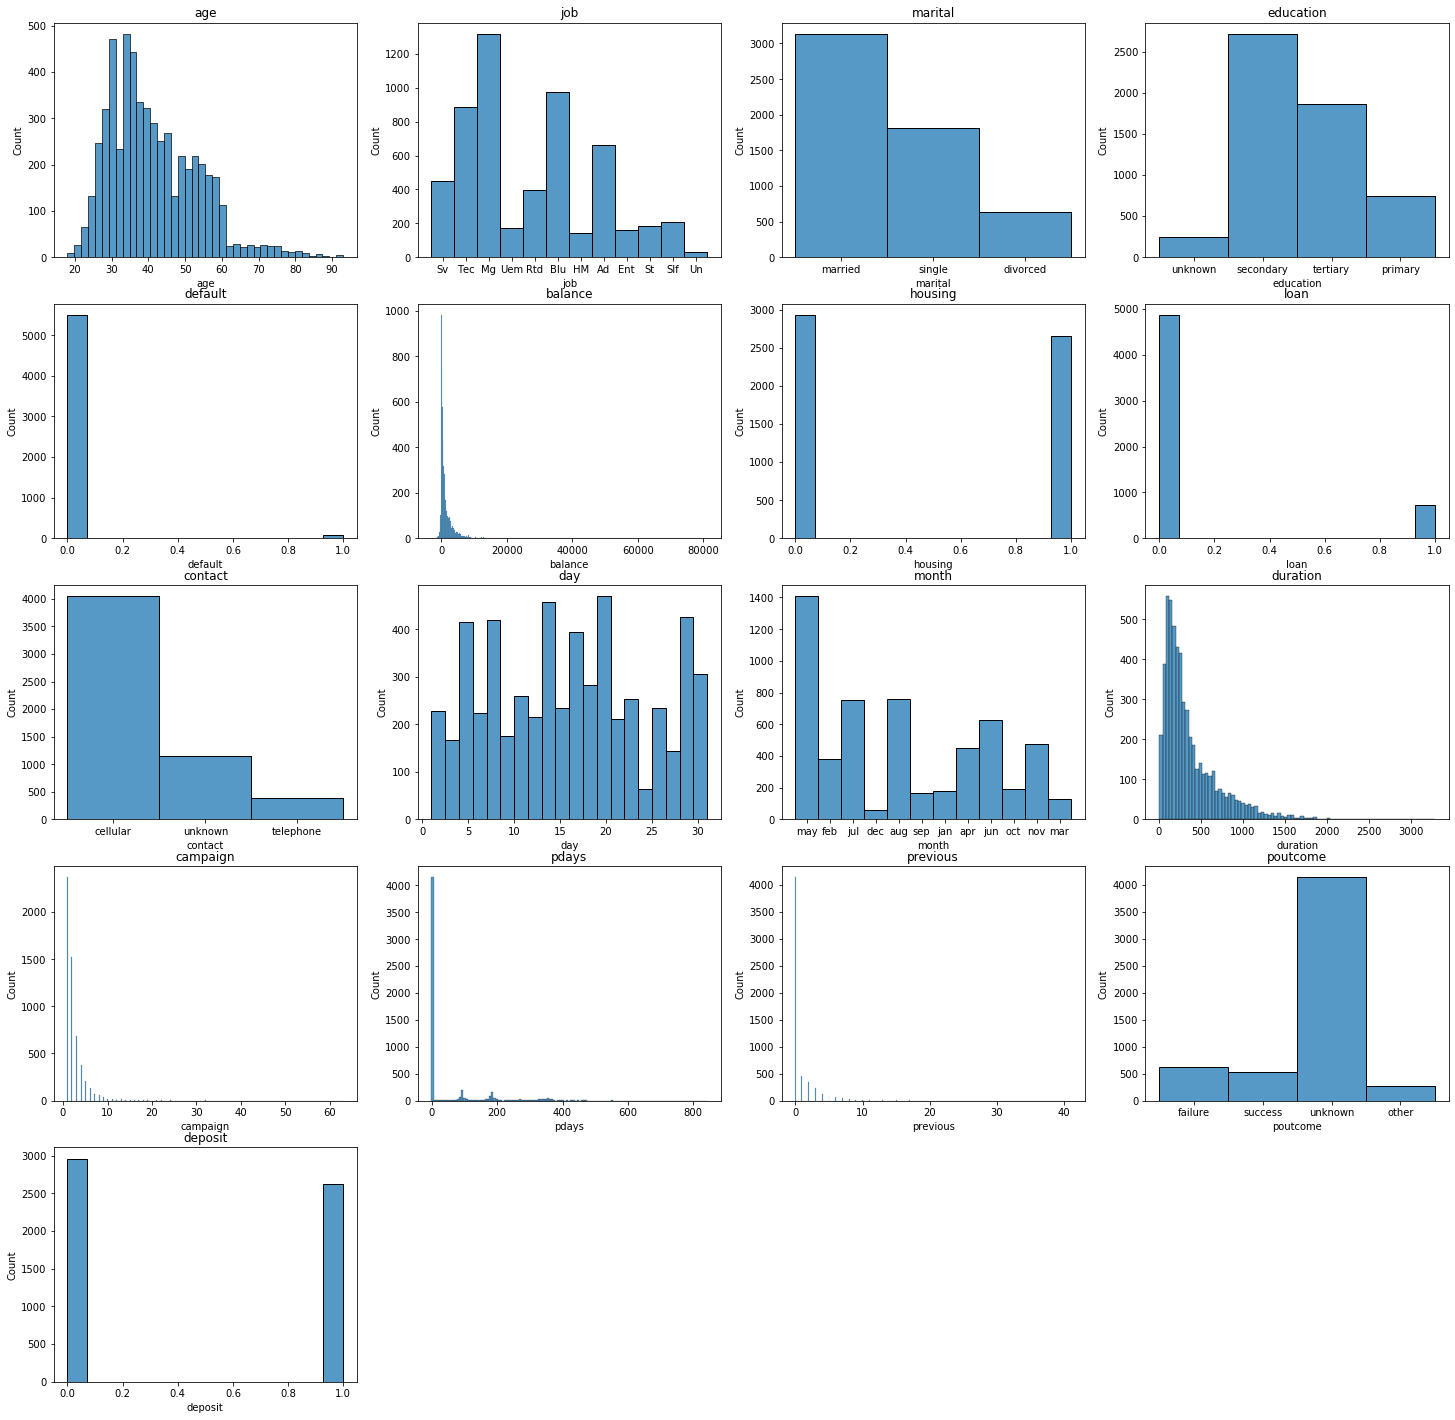

In [7]:
fig = plt.figure(figsize=(25, 25))
for i, col in enumerate(df.columns):
    ax = plt.subplot2grid((5, 4),(i//4, i%4))
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)

## Categorical feature histograms

Shown below are the histogram of each categorical feature. This illustrates both the number and frequency of each category in the dataset.

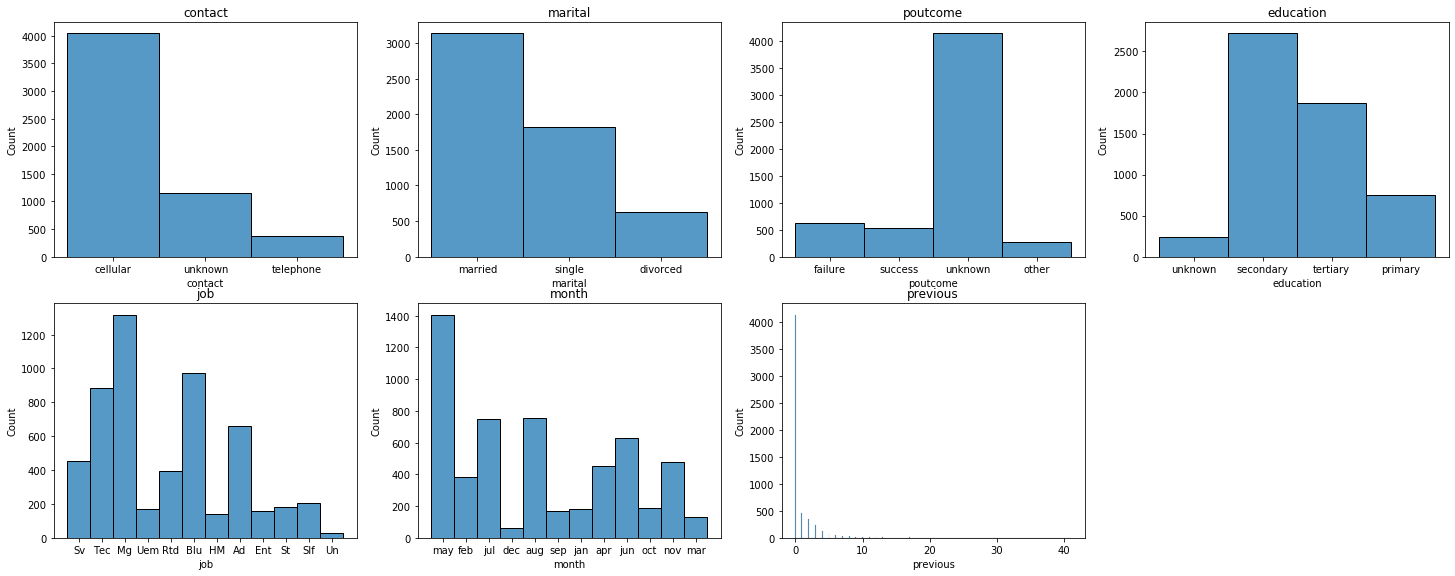

In [8]:
fig = plt.figure(figsize=(25, 25))
for i, col in enumerate(categorical_features):
    ax = plt.subplot2grid((5, 4),(i//4, i%4))
    sns.histplot(df[col], ax=ax)
    ax.set_title(col)

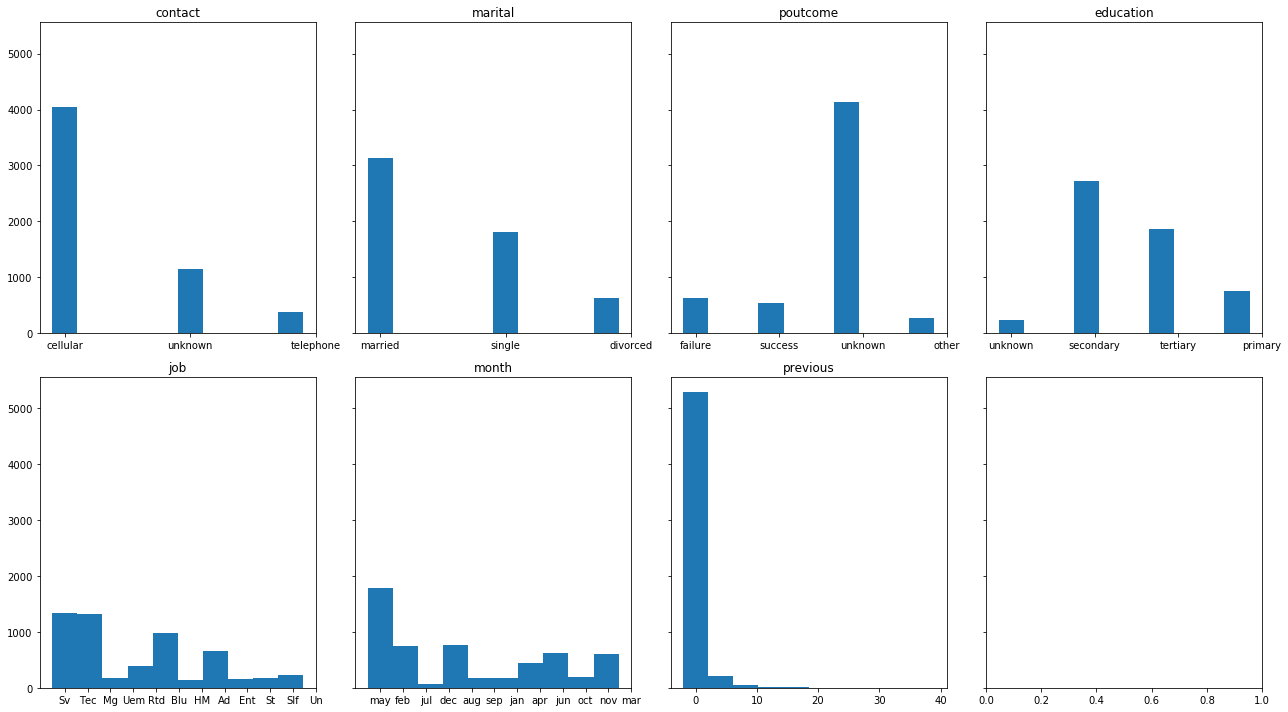

In [9]:
fig,axs = plt.subplots(2,4,figsize=(18,10),sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ax.hist(df[feat],align='left')
    ax.set_title(feat)
plt.tight_layout()

__How are claims distributed amongst the categorical features?__

As above, the bar plots again illustrate each categorical feature and value, but now also show how the proportion of claims is distributed to each categorical value. For example, single people have a relatively higher proportion of claims than married or divorced.

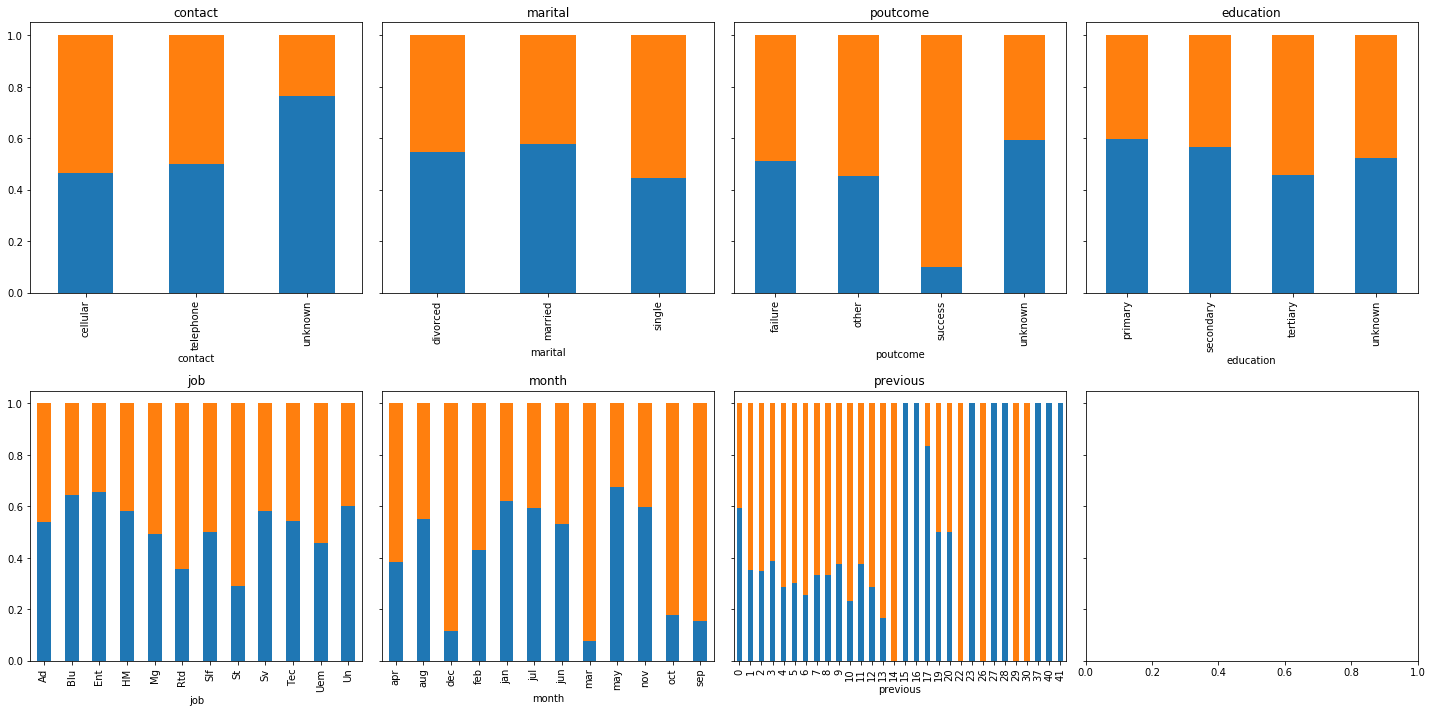

In [19]:
fig,axs = plt.subplots(2,4,figsize=(20,10),sharey=True)

for ax,feat in zip(axs.flatten(),categorical_features):
    ((pd.crosstab(df['deposit'],df[feat])) / (pd.crosstab(df['deposit'],df[feat]).sum())).T.plot.bar(stacked=True,ax=ax,legend=False,title=None)
    ax.set_title(feat)
plt.tight_layout()

# 3.3 __Clustering__
Recall that each clustering algorithm is an attempt to create natural groupings of the data. At a high-level, clustering algorithms acheive this using a measure of similarity or distance between each pair of data points, between groups and partitions of points, or between points and groups to a representative central point (i.e. centroid). So while the actual algorithm impementations to achive this vary, in essence they are based on this simple principle of distance.This is illustrated quite nicely in illustration below that shows a data set with 3 clusters, and iterative cluster partitioning a-f by updating the centroid points (Chen 2018). Here the clusters are formed by measuring the distance between each data point (solid fill) and a representative centoid point (hollow fill).

Because clustering algortithms utilise this concept of distance both it is crucial to consider both:

- Distance Meaasures. The distance or "similarity" measure used.
- Feature Engineering. The nature of our data and the way the data is presented the clustering algorithm.


# 3.3.1 __Distance Measures__
Below are some of the common distance measures used for clustering. Computational efficiency is important here as each data feature introduces an additional dimension.For clustering, by definition, we often have a multiple features to make sense of and therefore the efficiency of the calculation in high dimensional space is crucial.

Euclidean distance is the absolute numerical difference of their location in euclidean space. Distances can be 0 or take on any positive real number. It is given by the root sum-of-squares of differences between each pair (p,q) of points. And we can see that for high dimensions we simply add the distance.

$$d_n(p,q) = \sqrt{(p_1-q_1)^2+(p_2-q_2)^2...+(p_n-q_n)^2}$$
Manhattan distance is again the sum of the absolute numerical difference between two points in space, but using cartesian cooridantes. Whilst euclidean distance is the straight line "as the crow flies" with pythagorus theorem, Manhattan takes distance as the sum of the line vectors (p,q).

$$d_n(p,q)  = \sum_{i=1}^{n} |{(p_n-q_n)}|$$



There are many distance metrics. Minkowski distance for example, is a generalization of both the Euclidean distance and the Manhattan distance. Scipy has a covenient pair distance pdist() function that applies many of the most common measures.

>## __Example:__
>&emsp;      __```scipy.spatial.distance import pdist pdist(df,metric='minkowski')```__


There are also hybrid distance measures. In our case study, and topic of this article, the data contains a mixture of features with different data types and this requires such a measure.

## Gower (1971) distance is a hybrid measure that handles both continuous and categorical data.

If the data feature are continuous or ordinal, the Manhattan or a ranked ordinal Manhattan is applied respectively.
If the data feature are categorical, then a DICE coefficient is applied. DICE is explained here. However, If you are familiar with Jaccard coefficient and or binary classification (e.g. True Positives TP and False Posititves FP etc) and confusion matrices then DICE is going to be familiar as
$$DICE = \frac{2|X \cap Y|}{|X|+|Y|} = \frac{2TP}{2TP+FP+FN}$$
The Gower distance of a pair of points $G(p,q)$ then is:

$$G_n(p,q) = \frac{\sum_{i=1}^{n}W_{pqk}S_{pqk}}{\sum_{i=1}^{n}W_{pqk}}$$
where $S_{pqk}$ is either the Manhattan or DICE value for feature $k$, and $W_{pqk}$ is either 1 or 0 if $k$ feature is valid. Its the sum of feature scores divided by the sum of feature weights.

# 3.3.2 __Feature Engineering__
With this improved understanding of the clustering distance measures it is now clear that the scale of our data features is equally important. For example, imagine we were clustering cars by their performance and weight characteristics.

Car A does 0-60 mph in 3.5 seconds and has mass 3000 KG
Car B does 0-60 mph in 5.5 seconds and has mass 5000 KG
The feature distances between Car A and B are 2.0 seconds and 2000 KG. Thus our 2000 unit distance for mass is orders of magnitude higher than 2.0 seconds for 0-60 mph. Clustering data in this form would yield results bias toward high range features. When using any algorithm that computes distance or assumes normally distributed data, scale your features 4.

For datasets with mixed data-types consider you have scaled all features to between 0-1. This will ensure distance measures are applied uniformly to each feature. The numerical features will have distances with min-max 0-1 and real numbers between e.g. 0.1,0.2,0.5,...0.99. Whereas the distances for categorical feautures be values of either 0 or 1. As for mass KG in the car example above, this could still lead to a bias in the formation of clusters toward categorical feature groups as their distances are always either the min-max value of 0 or 1.

Selecting the appropriate transformations and scaling to apply is part science and part art. There are often several strategies that may suit and must be applied and evalauted in relation to the context of challenge at hand, the data and its domain. Crucially, whatever strategy is adopted, all features in the final dataset that is used for clustering data must be on the same scale for each eature to be treated equally by the distance metrics.

## Different data-types and how to handle them

In summary these are:

__Numerical features:__ continous and interval features such as mass, age, speed, luminosity, friction.

Use ratios and percentages.
normalisation (i.e. normalise values to be on scale of 0-1)
standardisation (i.e. how many standard deviations the value is from the sample mean)
transformation (i.e. log transformation).
__Nominal Categorical features:__ Unordered nominal or binary symmetric values where outcomes are of equal importance (e.g. Male or Female).

One-hot and dummy encoding (i.e. create binary indicator of each category).
If handling a feature with high cardinality >15, try to reduce dimensionality by feature engineering or apply binary or hash encoding.
__Ordinal Categorical features:__ Ordered ordinal or binary asymmetric values, where outcomes are not of equal importance.

>__Example:__ consider the ordinal categorical feautre for olmypic medals encoded as Bronze=1, Silver=2, Gold=3. Here bronze (= 1 1), silver (= 2 bronze), gold (= 3 * bronze). The difference between Gold-Bronze (= 3-1 = 2) is greater than between Gold and Silver (= 3-2 = 1) worse. Clearly this is ordinal as each category has a rank and relative scale comapred to each other category.

>- Label encoding with 0-1 normalisation if values are of equal-importance and on increasing scale.
>   - Rank values with 0-1 normalisation, again if values are on equal-importance increasing scale.
>    
>- If there is a binary target variable in the dataset (e.g. event occurence, medical diagnosis, iris type), one can also assign frequencies, odd ratios, or weights-of-evidence to each ordinal class.
By far ordinal data is the most challenging to handle. There are many arguments between mathmatical purists, statisticians and other data practitioners on wether to treat ordinal data as qualitatively or quantitatively (see here).

NOTE: Distance measures and encoding is perhaps THE hardest part to clustering data. In this authors opinion, especially for categorical and ordinal features, data should be treated with caution and practitioners should trial and evaluate different feature engineering and encdoing strategies based on their understanding of the data and its domain. My other recommendation is to trial and test different strategies first with smaller datasets and those where you have a reasonable understanding of what the clusters SHOULD be (Iris, Titanic). Valid your approach on these data, and then apply to you own data and build up the complexity from there deciding where to put more focus on tuning the encoding process. Here are some more useful links:

> Binary symmetric and assymetric variables
> datatype conversions in clustering
> Normalization vs Standardization — Quantitative analysis
> Normalization vs Standardization



  
# __3.3.3 Clustering Methods__
There are also considertions for the clustering algorithim that is applied. These will be introduced and discussed on application to the case study dataset in the results section.

# __4. Results__
## __4.1 Feature Engineering__
Scaling numerical features

Below, both Standard and MinMax scaling is applied to show how the data is transformed. The MinMax scaled data is used going forward.

In [20]:
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler


In [21]:
df[numerical_features][:2]

,default,day,campaign,age,pdays,duration,balance
0,0,11,1,41,336,105,88
1,0,26,1,56,192,229,1938


In [22]:
# Standard Scaled "mean normalisation"
scaler = StandardScaler()
scaler.fit(df[numerical_features])
print("Feature Means:\t",[f"{x:.2}" for x in scaler.mean_])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

Feature Means:	 ['0.015', '1.6e+01', '2.5', '4.1e+01', '5.3e+01', '3.7e+02', '1.5e+03']


,default,day,campaign,age,pdays,duration,balance
0,-0.123617,-0.554778,-0.544109,-0.014229,2.559623,-0.764824,-0.436813
1,-0.123617,1.218203,-0.544109,1.243635,1.259340,-0.404463,0.129587


In [23]:
# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[numerical_features])
numerical_data = scaler.transform(df[numerical_features])
numerical_data = pd.DataFrame(numerical_data,index=df.index,columns=numerical_features)
numerical_data[:2]

,default,day,campaign,age,pdays,duration,balance
0,0.0,0.333333,0.0,0.306667,0.399763,0.031088,0.037336
1,0.0,0.833333,0.0,0.506667,0.228944,0.068881,0.059291


  __Scaling categorical features: ordinal & nominal__

  Examining our EDA plots above, we may want to combine some classes where there are low target frequencies and or high cardinality. These are:
  Previous

  Previous: collapse >= 8 to single category

In [24]:
#pd.cut()
df['previous']= pd.cut(df['previous'],
                       bins=[0,1,2,3,4,5,6,8,9,50],
                       labels=[0,1,2,3,4,5,6,7,8],
                       include_lowest=True,
                       right=True).astype(float)

  Remember, nominal features are categoricals with values that have no order. Here, we could argue that EDUCATION and OCCUPATION are either nominal (i.e. unordered) or ordinal (i.e. ordered). This could be quite a debate....but there is a good argument to treat EDUCATION as ordinal and OCCUPATION as a categorical nominal. KIDSDRIV and HOMEKIDS can also be considered ordered and increasing in scale, however the adjustments we just made to the upper values are not symtetric in scale. This could be OK though given that there is very little data for the upper categories.

  Let's keep them as they are here. I will also apply MinMax scaling with range 0-1.

In [25]:
# create some lists
ordinal_features = ['education','previous','day']
print("Ordinals:\n",ordinal_features)

# apply order to education
df['education'] = df['education'].map({'unknown':0, 'primary':1, 'secondary':2,'tertiary':3})
ordinal_data = df[ordinal_features]

# MinMax scaled
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(df[ordinal_features])
ordinal_data = scaler.transform(df[ordinal_features])
ordinal_data= pd.DataFrame(ordinal_data,index=df.index,columns=ordinal_features)
ordinal_data[:5]

Ordinals:
 ['education', 'previous', 'day']


,education,previous,day
0,0.000000,0.125,0.333333
1,0.666667,0.375,0.833333
2,0.666667,0.000,0.233333
3,1.000000,0.000,0.533333
4,0.666667,0.000,0.433333


  For nominals that are binary features you can leave them as a single series indicator (e.g. Red Car Yes (1) or No (0)) or split them to two mutually exclusive one-hot-encoded series (e.g RedCarYes and RedCarNo). For some methods such as XGBoost the latter approach is preffered.

  Below I have written a for loop that keeps a single series for binary features and creates n-dimnesional feautres for nominal features with n+2 values.

  No need to scale here as all the values are either 0 or 1.

In [26]:
# For the nominals one-hot-encoding is applied
nominal_features = [c for c in categorical_features if c not in ordinal_features]
print("Nominals:\n",nominal_features)

nominal_data = list()
for i,x in df[nominal_features].nunique().iteritems():
    if x <= 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=True))
    elif x > 2:
        nominal_data.append(pd.get_dummies(df[[i]],drop_first=False))
        
nominal_data = pd.concat(nominal_data,axis=1)
nominal_data[:2]

Nominals:
 ['contact', 'marital', 'poutcome', 'job', 'month']


,contact_cellular,contact_telephone,contact_unknown,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0


## __Final Datasets used for clustering__

  We create two copies of the data:

1.   using the above OHE transformations and feature scaling (0,1).
2.   applying the above transformations but without feature scaling. The reason for this one is because some distance and clustering packages handle the preparation - but its good to know how to do it ourself.

In [27]:
# transformed and scaled dataset
Xy_scaled = pd.concat([numerical_data,nominal_data,ordinal_data],axis=1)
print(f'Data min:max {Xy_scaled.min().min(),Xy_scaled.max().max()}')

# original data
Xy_original = df[numerical_features+nominal_features+ordinal_features].copy()

Data min:max (0.0, 1.0000000000000002)


In [28]:
Xy_original

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
0,0,11,1,41,336,105,88,cellular,married,failure,Sv,may,0,1.0,11
1,0,26,1,56,192,229,1938,cellular,married,success,Tec,feb,2,3.0,26
2,0,8,2,30,-1,187,245,cellular,single,unknown,Sv,jul,2,0.0,8
3,0,17,1,34,-1,630,1396,cellular,single,unknown,Mg,jul,3,0.0,17
4,0,14,3,29,-1,512,-13,cellular,single,unknown,Tec,may,2,0.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,0,15,2,48,-1,755,2235,unknown,married,unknown,Ad,may,2,0.0,15
5577,0,4,3,40,340,195,-388,cellular,married,failure,Blu,may,1,0.0,4
5578,0,4,6,27,95,157,91,telephone,single,other,St,dec,2,8.0,4
5579,0,2,1,46,55,310,1568,cellular,married,other,Blu,jun,2,5.0,2


In [29]:
for i,col in enumerate(Xy_scaled.columns):
    Xy_scaled[col].fillna(Xy_scaled[col].mean(),inplace=True)
if Xy_scaled.isnull().sum().sum() == 0: print('No NaNs')



No NaNs


C:\Users\vikas\Anaconda3\lib\site-packages\pandas\core\generic.py:6244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [30]:
Xy_scaled

,default,day,campaign,age,pdays,duration,balance,contact_cellular,contact_telephone,contact_unknown,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,education,previous,day
0,0.0,0.333333,0.000000,0.306667,0.399763,0.031088,0.037336,1,0,0,...,0,0,0,1,0,0,0,0.000000,0.125,0.333333
1,0.0,0.833333,0.000000,0.506667,0.228944,0.068881,0.059291,1,0,0,...,0,0,0,0,0,0,0,0.666667,0.375,0.833333
2,0.0,0.233333,0.016129,0.160000,0.000000,0.056080,0.039199,1,0,0,...,1,0,0,0,0,0,0,0.666667,0.000,0.233333
3,0.0,0.533333,0.000000,0.213333,0.000000,0.191100,0.052859,1,0,0,...,1,0,0,0,0,0,0,1.000000,0.000,0.533333
4,0.0,0.433333,0.032258,0.146667,0.000000,0.155136,0.036137,1,0,0,...,0,0,0,1,0,0,0,0.666667,0.000,0.433333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,0.0,0.466667,0.016129,0.400000,0.000000,0.229198,0.062816,0,0,1,...,0,0,0,1,0,0,0,0.666667,0.000,0.466667
5577,0.0,0.100000,0.032258,0.293333,0.404508,0.058519,0.031687,1,0,0,...,0,0,0,1,0,0,0,0.333333,0.000,0.100000
5578,0.0,0.100000,0.080645,0.120000,0.113879,0.046937,0.037372,0,1,0,...,0,0,0,0,0,0,0,0.666667,1.000,0.100000
5579,0.0,0.033333,0.000000,0.373333,0.066429,0.093569,0.054900,1,0,0,...,0,1,0,0,0,0,0,0.666667,0.625,0.033333


## __4.2 Clustering methods for mixed datatypes__

  In this section several clustering algorithms and approaches are applied. However, first, some generic cluster evaluation techniques are introduced.

## __Evaluation techniques:__

  ***__Elbow plots, Silhouette Scores, and Silhouette Samples__***

In [31]:
from sklearn.cluster import KMeans
from matplotlib import cm
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

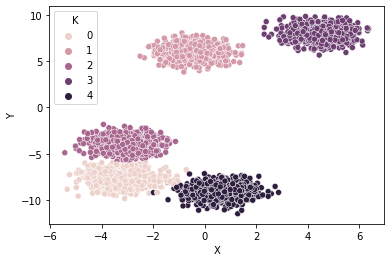

In [32]:
Xy_,clusters_ = make_blobs(n_samples=4000, centers=5, cluster_std=0.7)
df_ = pd.DataFrame(Xy_,columns=['X','Y'])
df_['K'] = clusters_
sns.scatterplot(x='X',y='Y',hue='K',data=df_);

  To help evaluate and identify the optimal number of clusters $k$ in a single plot, one can apply the following methods:

 - The clustering metric Elbow technique. We can directly use the clustering measure to evaluate the cluster results. For kmeans, clusters are created by minimising Intertia. The so called "elbow technique" plots intertia and the optimal number of clusters $k$ is selected as the point where intertia is inflected. The left plot below indicates that intertia stops changing substantially around $k=5$, the true number of clusters.

-  The silhouette score is a measure of cluster seperation and similarity. The score combines the the average intra-cluster difference and the nearest-cluster distance of each sample. With 1 being best "all cluster samples are similar" and -1 being worst "clusters are dissimila and overlapping". The sklearn silhouette_score() function can in-fact calculate any pairwise distance metric from sklearn or scipy.spatial.distance. For KMeans, euclidean distance is the default score but we can also use Correlation, Manhattan, etc metrics. As for the Elbow approach, $k$ is selected that optimises the selected metric.

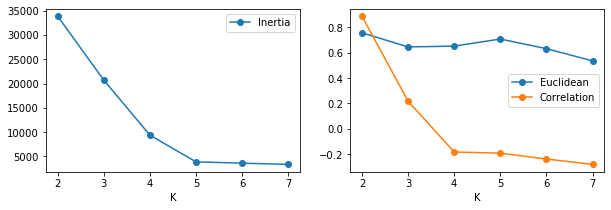

In [33]:
results = dict()
k_cand = [2,3,4,5,6,7] #

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,2,sharex=True,figsize=(10,3))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

  Selecting the optimal value for $k$ can also be aided by closer inspecting the samples and clusters themselves. Sklearn has a nice tutorial here. These include:

-   Silhouette Samples show the per data point silhouette score within a cluster (left). The coloured bars are the data points within eac cluster, where width is the data point silhouette score. The vertical dashed line is the average score per data point across all clusters. The cluster bard group height indicates the size of the cluster. Clusters and samples with "noisy" silhouette plots in terms of unequal widths and heights indicates poor clustering.

-   Cluster centroids (right). Accompanying the silhouette sample plots, the data clusters and centroids are shown explicitly.

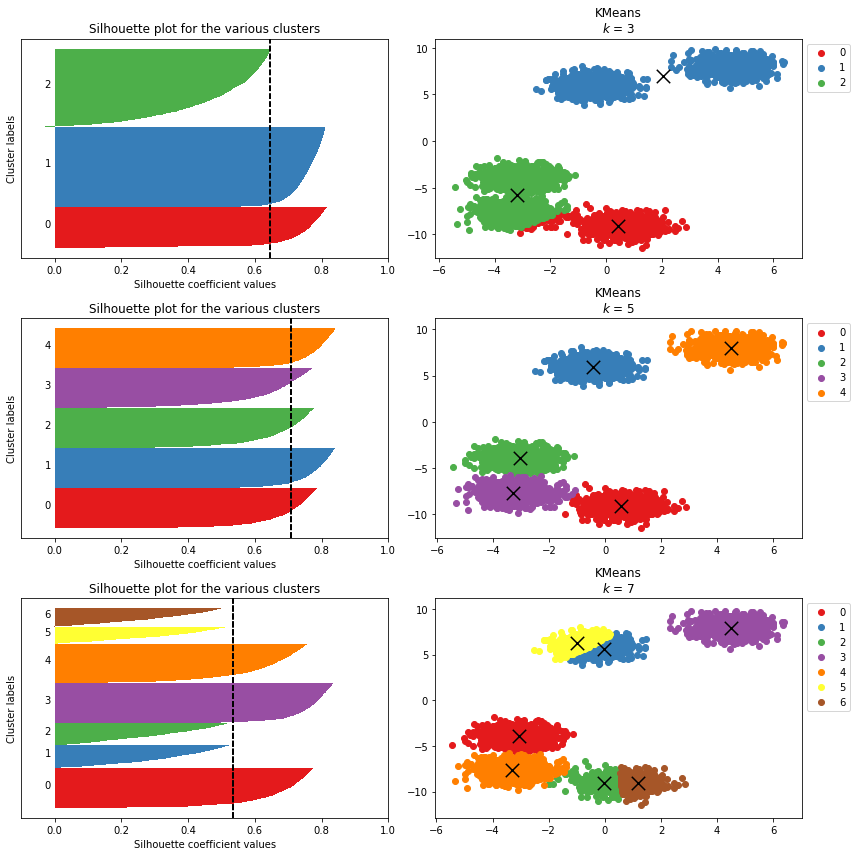

In [34]:
k_cand = [3,5,7]

fig,axs = plt.subplots(len(k_cand),2,figsize=(12,12))

for e,k in enumerate(k_cand):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_)
    
    cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
    
    ## silhouette samples
    silhouette_vals = silhouette_samples(Xy_,kmeans.labels_)
    y_lower = 0 
    y_upper = 0
    for i,cluster in enumerate(np.unique(kmeans.labels_)):
        cluster_silhouette_vals = silhouette_vals[kmeans.labels_==cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        axs[e,0].barh(range(y_lower,y_upper),
                      cluster_silhouette_vals,
                      height=1,
                      color=cdict[cluster])
        axs[e,0].text(-0.03,(y_lower+y_upper)/2,str(i))
        
        y_lower += len(cluster_silhouette_vals) # add for next iteration 
        avg_score = np.mean(silhouette_vals)
        axs[e,0].axvline(avg_score,linestyle ='--',color = 'black')
        
        axs[e,0].set_yticks([])
        axs[e,0].set_xlim([-0.1, 1])
        axs[e,0].set_xlabel('Silhouette coefficient values')
        axs[e,0].set_ylabel('Cluster labels')
        axs[e,0].set_title('Silhouette plot for the various clusters')
        
    ## plot data and cluster centroids
    results = pd.DataFrame(Xy_)
    results['k'] = kmeans.labels_
    for cluster in np.unique(kmeans.labels_): # plot data by cluster
        axs[e,1].scatter(x=results.where(results['k']==cluster)[0],
                         y=results.where(results['k']==cluster)[1],
                         color=cdict[cluster],
                         label=cluster)
    # plot centroids
    axs[e,1].scatter(x=kmeans.cluster_centers_[:,0],
                     y=kmeans.cluster_centers_[:,1],
                     marker='x',color='black',s=180)
    axs[e,1].legend(bbox_to_anchor=(1,1))
    axs[e,1].set_title(f"KMeans\n$k$ = {k}")
    plt.tight_layout()

  For the scatter plots. If you have multiple features in your clustering data, or otherwise do not have the distance matrix, then first you must apply a decomposition technique such as PCA, MCA, or t-SNE to obtain a 2 or 3 dimensional vectors for plotting.

>  __NOTE__ use t-SNE with caution as this alters the scale and magnitude of the feature spaces and some methods, such as plotting centroids, will not work as shown below. See here and here for explanations and guidance using t-SNE.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 4000 samples in 0.011s...
[t-SNE] Computed neighbors for 4000 samples in 0.159s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4000
[t-SNE] Computed conditional probabilities for sample 2000 / 4000
[t-SNE] Computed conditional probabilities for sample 3000 / 4000
[t-SNE] Computed conditional probabilities for sample 4000 / 4000
[t-SNE] Mean sigma: 0.498599
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.950539
[t-SNE] KL divergence after 500 iterations: 1.548060


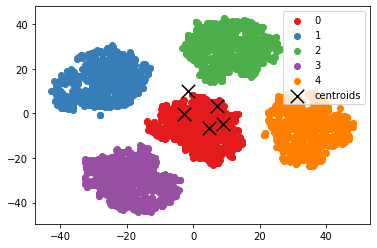

In [35]:
a,b = make_blobs(n_samples=4000,n_features=5, centers=5, cluster_std=0.7)
kmeans = KMeans(n_clusters=5, random_state=0).fit(a)

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(a)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.scatter(kmeans.cluster_centers_[:,0],
            kmeans.cluster_centers_[:,1],
            marker='x',color='black',s=180,
            label='centroids')
plt.legend();

## __4.2.1 K-Means__
  The KMeans algorithm attempts to cluster data by creating groups that minimise the within-cluster sum-of-squared differences, aka inertia. Inertia measures the similarity of each pair of points as the Euclidean distance between them, smaller distances == higher similarity. The KMeans algorithm is computed in 3 steps:

1.   $k_n$ initial random centroids are chosen.
2.   data points are assigned to their nearest $k_i$ centroid.
3.   new centroids are created as the mean location of $k_i$ and its assigned points. Step 2 and 3 are repeated on the new cetroids until there is little to no change between iterations.


  KMeans works well on large datasets with numerical features, uniform cluster size, and where clusters are convex and isotropic "blobs". For a full description of KMeans and its limitations see sklearn KMeans documentation.

  For high-dimensional data (e.g. lots of features) and with mixed data-types, there is a high likelihood that the Intertia and Euclidean distances become insignificant due to the curse of high dimensionality. Simply put, in high-dimensional space and with independantly distributed features (i.e. no correlation) it is typical that the pairwise distances between any and all points becomes very small. This could well be a problem for our data set with categorical features.

  Applying KMeans to our scaled dataset shows there may be a high number of clusters. This may reflect some actual clusters within the data. But it may also be an artefact of having mixed numerical and categorical features and limitations of KMeans given high dimensionality of the data.

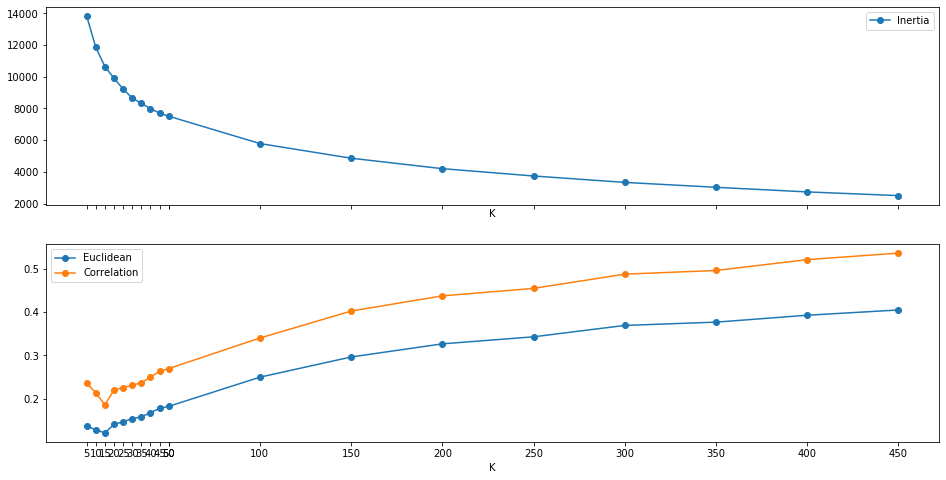

In [36]:
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(Xy_scaled)
    score0 = kmeans.inertia_
    score1 = silhouette_score(Xy_scaled,kmeans.labels_,metric='euclidean')
    score2 = silhouette_score(Xy_scaled,kmeans.labels_,metric='correlation')
    results[k] = {'k':kmeans,'s0':score0,'s1':score1,'s2':score2}

fig,axs = plt.subplots(2,1,sharex=True,figsize=(16,8))
axs[0].plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Inertia')
axs[1].plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Euclidean')
axs[1].plot([i for i in results.keys()],[i['s2'] for i in results.values()],'o-',label='Correlation')
for ax in axs:
    ax.set_xticks(k_cand)
    ax.set_xlabel('K')
    ax.legend()

  As $k$ increases inertia and silhouette scoring is shown to improve. There are simply too many $k$ to make silhouette sampling and centroid plotting viable, however we can plot this using t-SNE to visually inspect what is happening. Albeit crudely. There seems to be a degree of good seperation in the t-SNE plot but also with some larger blobs of mixed colours.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5581 samples in 0.076s...
[t-SNE] Computed neighbors for 5581 samples in 1.728s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5581
[t-SNE] Computed conditional probabilities for sample 2000 / 5581
[t-SNE] Computed conditional probabilities for sample 3000 / 5581
[t-SNE] Computed conditional probabilities for sample 4000 / 5581
[t-SNE] Computed conditional probabilities for sample 5000 / 5581
[t-SNE] Computed conditional probabilities for sample 5581 / 5581
[t-SNE] Mean sigma: 0.461350
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.722244
[t-SNE] KL divergence after 500 iterations: 1.004182


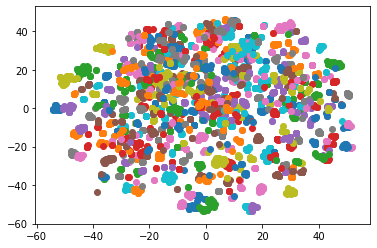

In [37]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(Xy_scaled)
tsne = pd.DataFrame(tsne)
tsne['k'] = results[400]['k'].labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1]
               )

  Herein lies another problem of unsupervised learning - what are the correct clusters? There is no definitive answer in this case. You will have to apply a blend of domain knowledge and expertise with the clustering results and interpretation to derive the most meaningfull insights from the clusters. Here you can utilise other methods, diagnostic statistics, and visualisations, to interpret and assess your clusters. These might include:

-   association tests: correlation, cramer's V, chi-square tests
-   box plotting and distribution tests between clusters
-   classification: build decision tree's with $k$ as the target and explain clusters using feature importance and shap values

In [38]:
xy = Xy_original.head()
xy

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
0,0,11,1,41,336,105,88,cellular,married,failure,Sv,may,0,1.0,11
1,0,26,1,56,192,229,1938,cellular,married,success,Tec,feb,2,3.0,26
2,0,8,2,30,-1,187,245,cellular,single,unknown,Sv,jul,2,0.0,8
3,0,17,1,34,-1,630,1396,cellular,single,unknown,Mg,jul,3,0.0,17
4,0,14,3,29,-1,512,-13,cellular,single,unknown,Tec,may,2,0.0,14


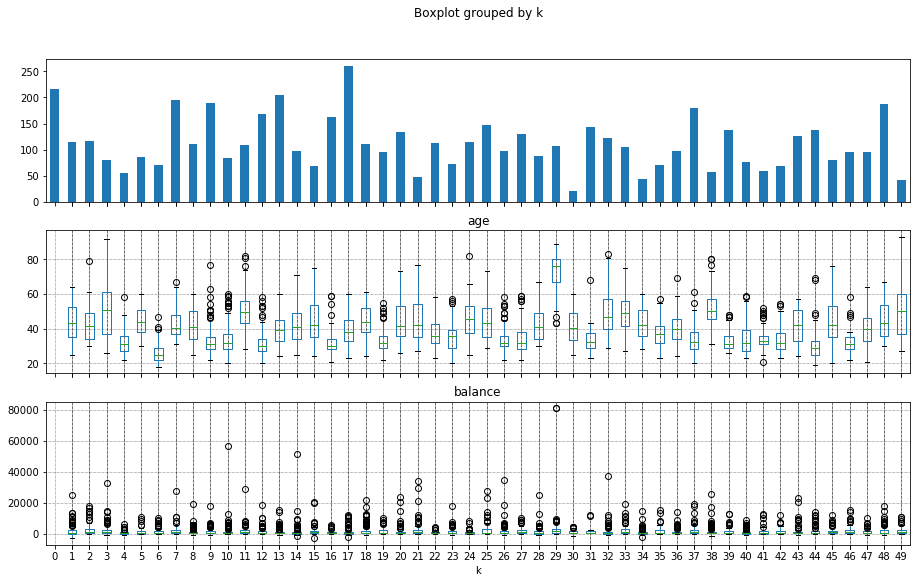

In [39]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=True)
Xy_original['k'] = results[50]['k'].labels_

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='age',ax=axs[1])
Xy_original.boxplot(by='k',column='balance',ax=axs[2])

#Remove contact marital poutcome job and month for the below code to work
#Xy_original.groupby('k').agg(["mean", "median", "var"])[:2]


In [40]:
Xy_original.drop(labels=['k'],axis=1,inplace=True)


## __4.2.2 K-medoids__
  K-medoids is similar to Kmeans, but uses an actual data point "medoid" to form clusters rather than the mean value "centroid" location of data wihtin a cluster. K-medoids also takes different distance metrics to Kmeans, inlcuding Manhattan and Minkowski suited to mixed dataype datasets such as ours. Whilst this makes K-medoids more robust to outliers and feature scale, this is at the expense of added computation and hence is poor perfoming on large datasets and where $k$ is high.

  K-medoids has several implementations in Python. PAM (partition-around-medoids) is common and implmented in both pyclustering and scikit-learn-extra. 

In [41]:
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import pdist,squareform

  K-medoids can be calculated using many distance metrics. Here the Manhattan or "cityblock" distance is used as this provides a suitable measure where there are both categorical and numerical features. Manhattan distances are computed on the transformed and scaled data set as scipy.pdist does not perform feature transformation itself.

In [42]:
mhv = pdist(Xy_scaled, 'cityblock',)
mh = squareform(mhv,force='tomatrix')
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {mh.shape}")
pd.DataFrame(mh[:3,:3])

Data shape: (5581, 15)
Matrix shape: (5581, 5581)


,0,1,2
0,0.000000,8.347234,7.581081
1,8.347234,0.000000,10.199633
2,7.581081,10.199633,0.000000


  __Note__ In contrast to scikit, pyclustering return clusters in an $n$ length list of lists, where $n=k$ and $list$[$n$][$i$] is the index postion from the input distance matrix. These are converted to flat array format.

Wall time: 14.7 s
Wall time: 24.4 s


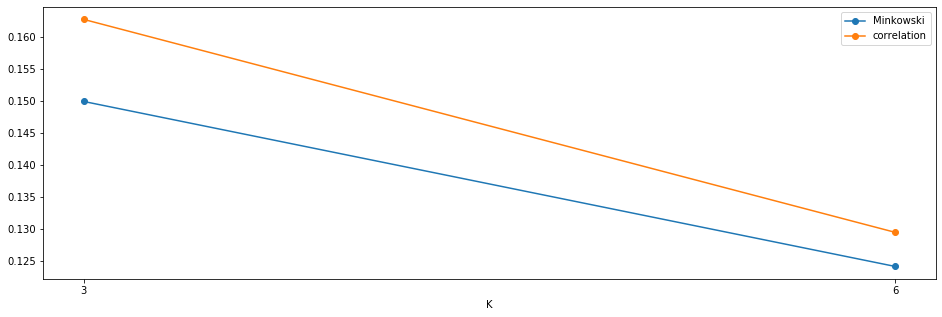

In [65]:
# find k clusters
results_kmedoids = dict()

k_cand = [3,6]

for k in k_cand:
    # initiate k random medoids - sets k clusters
    initial_medoids = np.random.randint(0,1000,size=k)
    kmedoids_instance = kmedoids(mh,
                                 initial_medoids,
                                 data_type='distance_matrix')    

    # run cluster analysis and obtain results
    %time kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()

    # convert cluster output
    cluster_array = pd.DataFrame([(x,e) for e,i in enumerate(clusters) for x in i if len(i)>1]).sort_values(by=0)[1].values
    
    # score
    score1 = silhouette_score(mh, cluster_array, metric='precomputed')
    score2 = silhouette_score(Xy_scaled, cluster_array,metric='correlation')
    
    # store
    results_kmedoids[k] = {'k':cluster_array,'s1':score1,'s2':score2}

fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results_kmedoids.keys()],[i['s1'] for i in results_kmedoids.values()],'o-',label='Minkowski')
axs.plot([i for i in results_kmedoids.keys()],[i['s2'] for i in results_kmedoids.values()],'o-',label='correlation')
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

## __4.2.3 CLARANS__
  CLARANS stands for Clustering Large Applications based on RANdomized Search.There is a good write up of CLARANS here. Briefly, CLARANS builds upon the k-medoid and CLARA methods. The key difference in CLARANS is that cluster centers "centroids" or "medoids" are defined through a limited number of rounds of random sampling and of a limited number of neighbourig points. Crucially, the sampling is not limited to just the neighbouring data of a centroid, but may include any point within the entire dataset. Thus avoiding the development of local minima as in CLARA. The CLARANS paper details this and other methods such as k-medoids so is worth a read Raymond 2002.

  The CLARANS implementation in pyclustering requires list of lists as its input dataset. Thus we convert the transformed and scaled features data from numpy array to a list. The other inputs are as follows:

-   Input data that is presented as list of points (objects), each point should be represented by list or tuple.
-   number_clusters: amount of clusters that should be allocated.
-   numlocal: the number of local minima obtained (amount of iterations for solving the problem).
-   maxneighbor: the maximum number of neighbors examined. The higher the value of maxneighbor, the closer is CLARANS to K-Medoids, and the longer is each search of a local minima.
  Note that clarans.py uses Euclidean distance metric. There is no functional reason limiting the CLARANS algortihm to use Euclidean distance and below I have made a custom class locally cclarans using Manhattan distance.

In [49]:
# customised clarans using Manhattan distance
from cclarans import clarans
from pyclustering.utils import manhattan_distance,euclidean_distance_square

#manhattan_distance([1,1],[1,2]),euclidean_distance_square([1,1],[1,2])
#manhattan_distance(Xy_scaled_list[0],Xy_scaled_list[1])

Xy_scaled_list = Xy_scaled.to_numpy().tolist()
len(Xy_scaled_list)

clarans_instance = clarans(data=Xy_scaled_list,
                            number_clusters=10,
                            numlocal=1, 
                            maxneighbor=3)
#%time clarans_instance.process()
#clusters = clarans_instance.get_clusters()

  __OK!__ As for K-medoids something is clearly not right here. Our supposedly efficient CLARANS is grinding through taking 1 hours to compelete 1 iteration of candidate $k$.

  To confirm that this is not an implementation issue, below is a run of CLARANS on synthetic data of equal size. And which takes less than around 60 seconds to run.

Wall time: 43.6 s


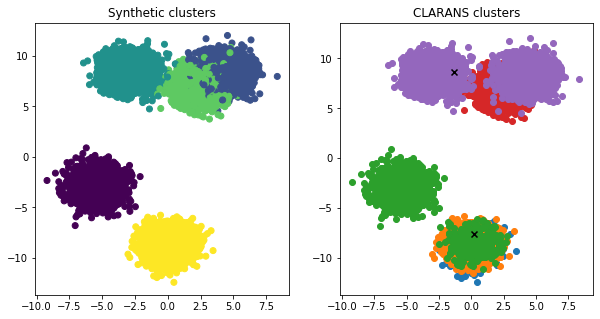

In [50]:
from pyclustering.cluster.clarans import clarans
from sklearn.datasets import make_blobs

# synthetic clusters
I,c = make_blobs(10302,n_features=36,centers=5)

# implement clarans
clarans_instance = clarans(I.tolist(), 5, 2, 4);
%time clarans_instance.process()
clusters = clarans_instance.get_clusters()
medoids = clarans_instance.get_medoids()

fig,axs=plt.subplots(1,2,figsize=(10,5))
axs[0].scatter(I[:,2],I[:,1],c=c)
axs[0].set_title('Synthetic clusters')
axs[1].set_title('CLARANS clusters')
for c_,m in zip(clusters,medoids):
    axs[1].scatter(I[c_,2],I[c_,1])
    axs[1].scatter(I[m,2],I[m,1],marker='x',c='black',label='medoids')

  As illustrated above, K-means, K-medoids, and CLARANS, are all suited to flat geometry. That is they are suitable for clusters that form convex hulls. Non-flat geometrical clusters include classical shapes such as spirals, crescents, and concentric rings.

  Given the issues and shortcomings of these alogrithms, and euclidean distance in high demnsional cases, we will now apply alternative distance metrics and clustering algorithms suited to high dimensional non-flat geometry. This includes hierachal, spectral, or density based approaches such as HDBSCAN.

## __4.2.4 Agglomerative Hierarchical Clustering with Gower__
  Agglomerative Clustering is a hierarchical clustering algorithm. In agglomerative clustering, each data point is initially considered as a single cluster, which are then iteratively merged (agglomerated) until all data points form one large cluster. The optimal number of clusters $k$ is found by minimising intra-cluster data point distances and maximising the distance between each unique cluster,

  The Gower distance is a hybrid metric suited to datasets with mixed datatypes. Gower is implemented here in Gower Python. For R users there is Gower R.



In [51]:
import gower

  Gower has two core functions, gower_topn and gower_matrix. Handily, as per the source code gower also comes with the functionality to handle feature normalisation and scaling so we could pass either our raw or transformed and scaled data.

  The gower_topn can be used to find $n$ items related to a single row of data. This could be useful for quickly finding similar customers customers or for making movie recommendations for instance. Below I choose a random row of data and find the tp 5 similar items.

In [52]:
cat = [True if x in categorical_features else False for x in Xy_original.columns]

n = 5
focus = Xy_original.sample(1)
similar = gower.gower_topn(focus,Xy_original,
                           n=n,cat_features=cat)
focus

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
3123,0,7,1,45,-1,118,891,unknown,married,unknown,Uem,jan,2,0.0,7


  Gower returns the index locations and similarity values.

In [53]:
print(similar['values'])
Xy_original.iloc[similar['index']]

[0.         0.07473415 0.08182521 0.08415686 0.08538792]


,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day
3123,0,7,1,45,-1,118,891,unknown,married,unknown,Uem,jan,2,0.0,7
1526,0,6,1,46,-1,23,-125,unknown,married,unknown,Uem,may,2,0.0,6
1942,0,9,2,48,-1,241,855,unknown,married,unknown,Uem,may,2,0.0,9
1421,0,6,3,56,-1,72,660,unknown,married,unknown,Uem,jun,2,0.0,6
5048,0,5,1,40,-1,357,219,unknown,married,unknown,Uem,may,2,0.0,5


In [54]:
# create list of cat_feature indicator
cat = [True if x in categorical_features else False for x in Xy_original.columns]

%time gd = gower.gower_matrix(Xy_original, cat_features=cat)

Wall time: 26.3 s


  Calculating the entire matrix may take some time. Once complete Gower returns the full distance matrix.

In [55]:
print(f"Data shape: {Xy_original.shape}\nMatrix shape: {gd.shape}")
pd.DataFrame(gd[:3,:3])

Data shape: (5581, 15)
Matrix shape: (5581, 5581)


,0,1,2
0,0.000000,0.428704,0.385961
1,0.428704,0.000000,0.454976
2,0.385961,0.454976,0.000000


  The scipy.linkage function is used to perform the hierachal agglomerative clusering. There are a few important considerations here.

-   linkage requires a 1D condensed matix as input. We can use np.squareform to tranform the gower matrix.
-   Some linkage methods may only be applied to Euclidean distances. "Methods ‘centroid’, ‘median’, and ‘ward’ are correctly defined only if Euclidean pairwise metric is used." see the documentation for detail.
  Returned is a ($n-1$) by 4 matrix $Z$. At the $i$-th iteration, clusters with indices $Z[i, 0]$ and $Z[i, 1]$ are combined to form a cluster.The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is given by $Z[i, 2]$. The fourth value $Z[i, 3]$ represents the number of original observations in the newly formed cluster. The format of $Z$ may be a little confusing at first.

In [56]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

In [57]:
# condensed matrix
gdv = squareform(gd,force='tovector')

# output matrix has format [idx1, idx2, dist, sample_count]
Z = linkage(gdv,method='complete')
Z_df = pd.DataFrame(Z,columns=['id1','id2','dist','n'])
Z_df[:2]

,id1,id2,dist,n
0,1923.0,2445.0,0.000799,2.0
1,788.0,5543.0,0.000916,2.0


  Visualise the hierachal clusters using a scipy.dendogram. Each level and leaf in the dendogram represents a cluster. Clearly displaying the hierachal nature of agglomerative clustering.

Leaves = 64


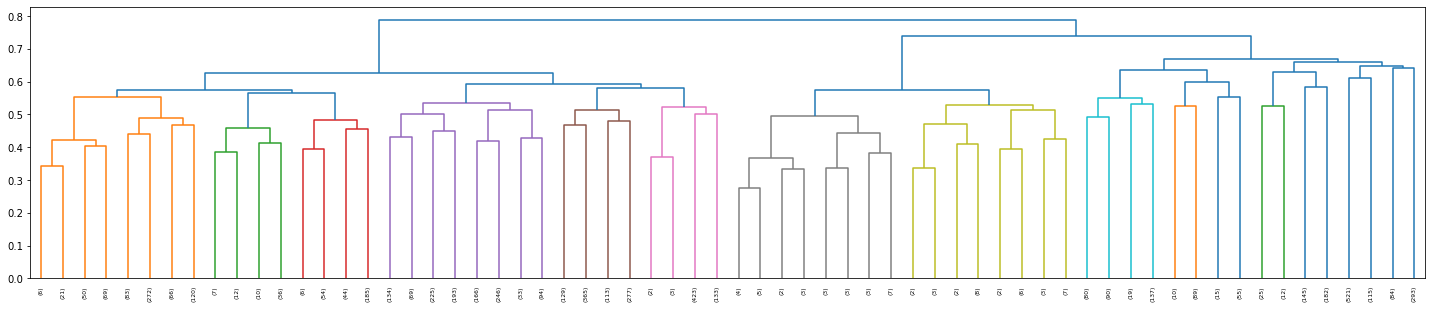

In [58]:
fig,axs = plt.subplots(1,1,figsize=(25,5))
dn = dendrogram(Z, truncate_mode='level',p=5,show_leaf_counts=True,ax=axs);
print(f"Leaves = {len(dn['leaves'])}")

  To find the optimal number of clusters we can again apply silhouette scoring. First, scipy.fcluster is applied to to form flat clusters from the hierarchical clustering linkage matrix ($Z$).

  Silhuoette scores are calculated using:

-   the precomputed Gower distances in the full gower matrix.
-   using correlation

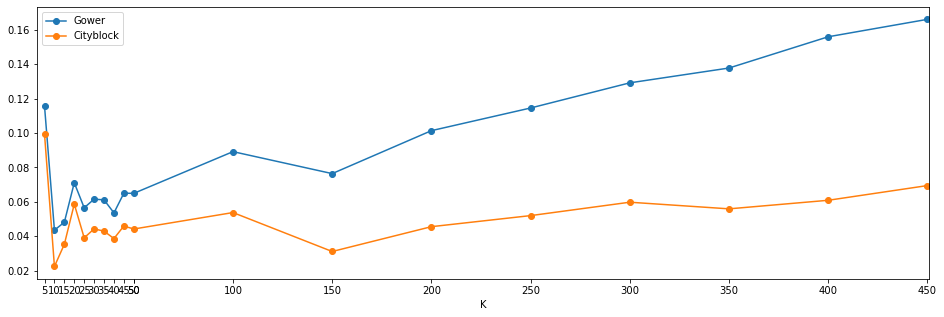

In [59]:
# find k clusters
results = dict()
k_cand = list(np.arange(5,55,5))
k_cand.extend(list(np.arange(50,500,50)))

for k in k_cand:
    cluster_array = fcluster(Z, k, criterion='maxclust')
    score0 = silhouette_score(gd, cluster_array, metric='precomputed')
    score1 = silhouette_score(Xy_scaled, cluster_array,metric='cityblock')
    results[k] = {'k':cluster_array,'s0':score0,'s1':score1}
    
fig,axs = plt.subplots(1,1,figsize=(16,5))
axs.plot([i for i in results.keys()],[i['s0'] for i in results.values()],'o-',label='Gower')
axs.plot([i for i in results.keys()],[i['s1'] for i in results.values()],'o-',label='Cityblock')
axs.set_xlim(1,451)
axs.set_xticks(k_cand)
axs.set_xlabel('K')
axs.legend();

  Visualising the silhouette scores and plots shows an interesting result. This new round of clusters appears to have an optimal $k$ of around 5, 10, and 35. As happened previously using Kmeans, silhouette scores are shown to improve once $k$ exceeed 100. However, the correlation scores are flat and this is again indicative of small unique groups.

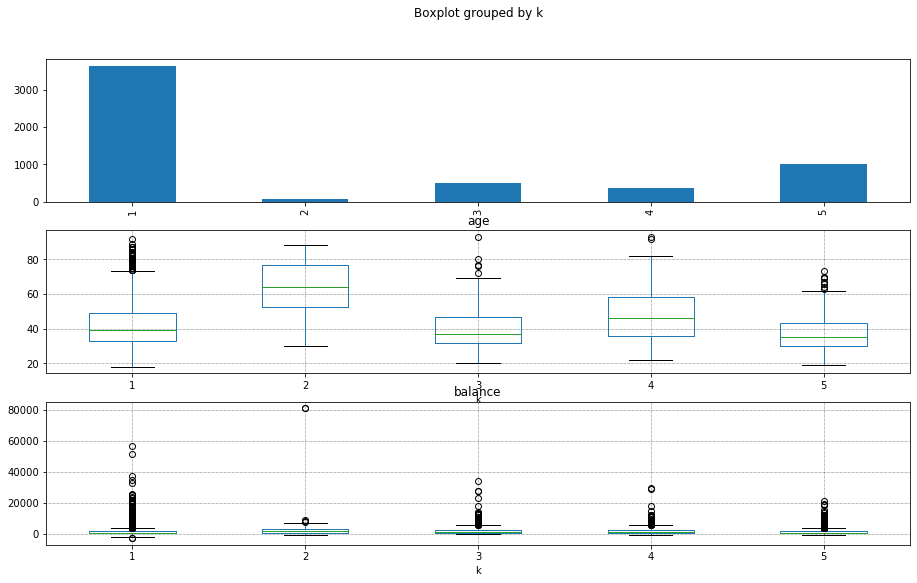

In [60]:
fig,axs = plt.subplots(3,1,figsize=(15,9),sharex=False)
Xy_original['k'] = results[5]['k']

Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='age',ax=axs[1])
Xy_original.boxplot(by='k',column='balance',ax=axs[2])

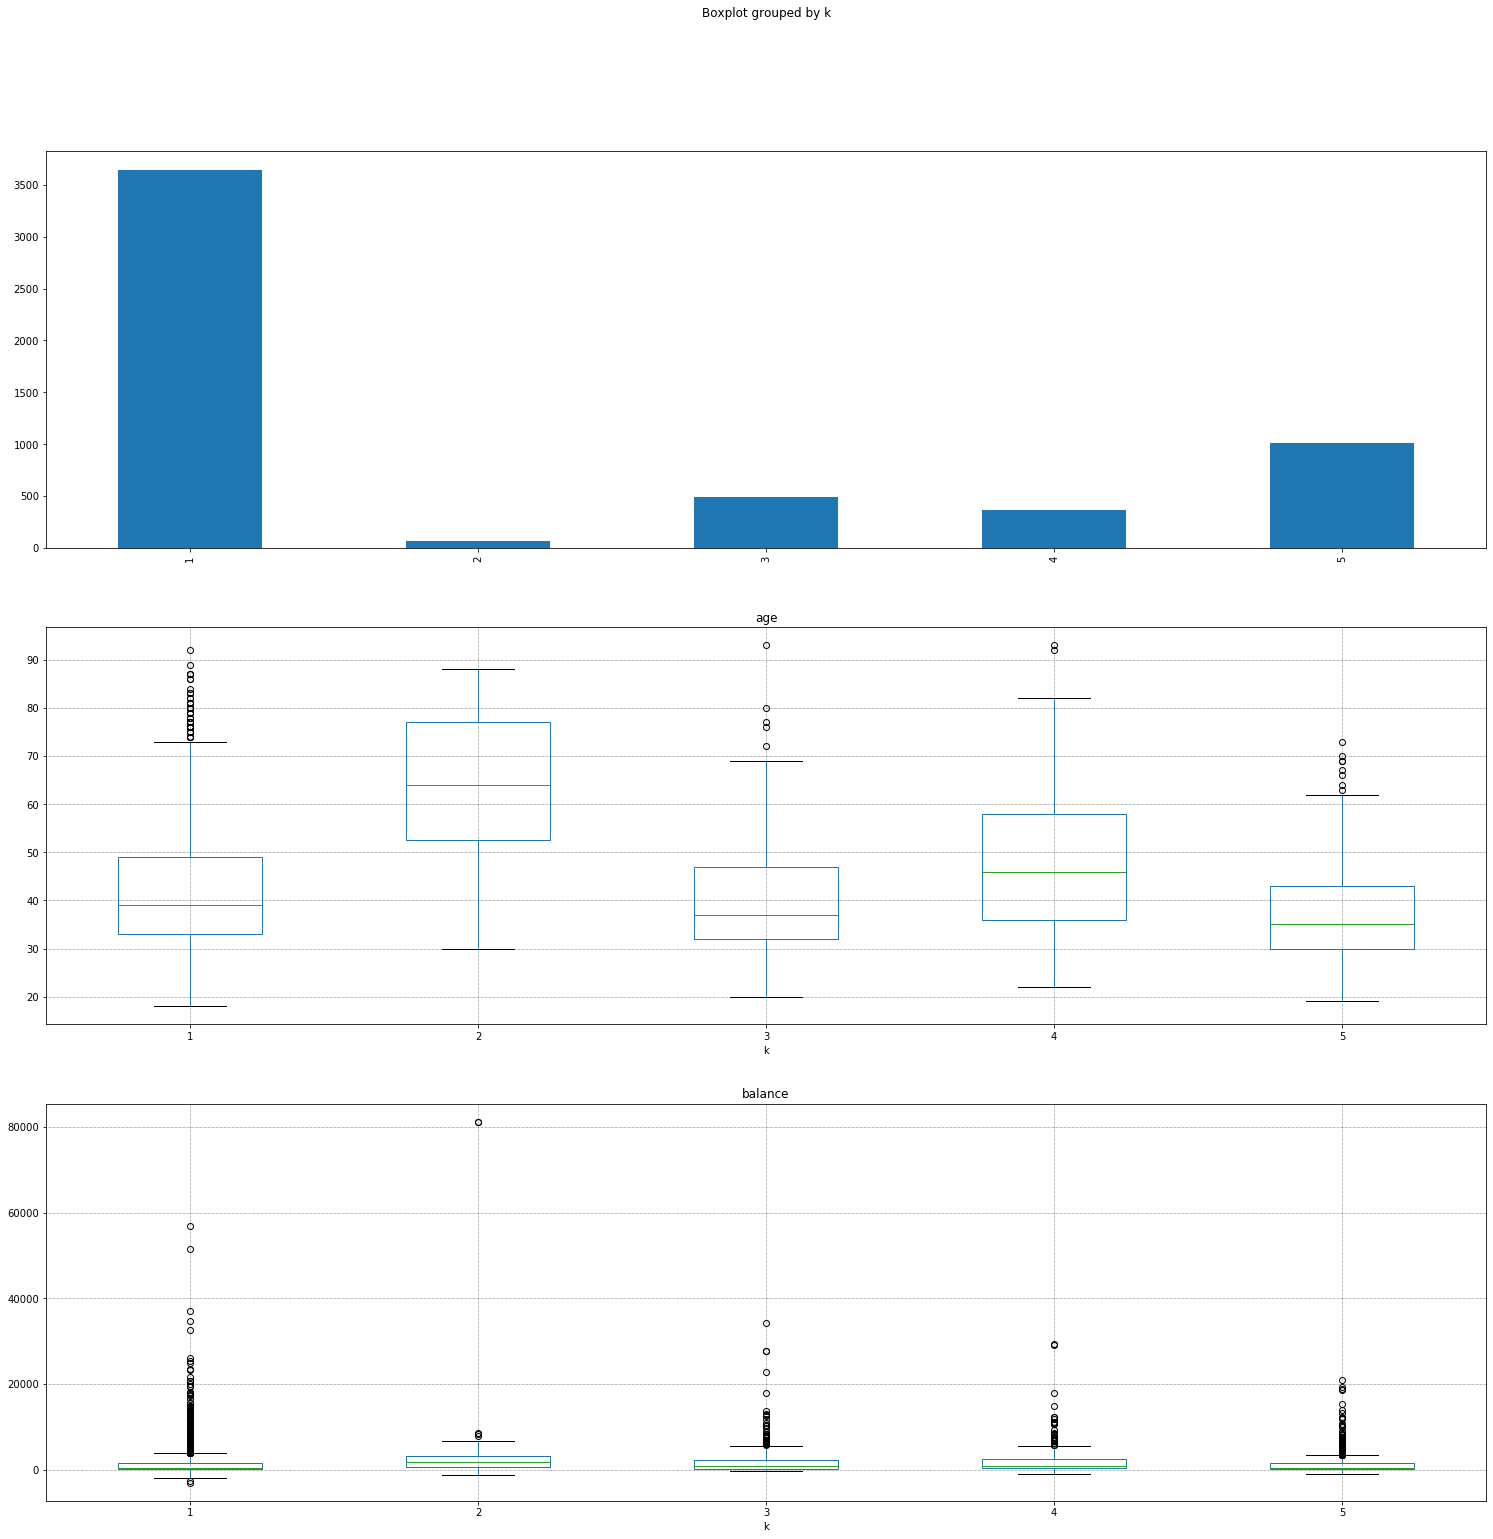

In [61]:

fig,axs = plt.subplots(3,1,figsize=(25,25),sharex=False)
Xy_original['k'].value_counts().sort_index().plot.bar(ax=axs[0])
Xy_original.boxplot(by='k',column='age',ax=axs[1])
Xy_original.boxplot(by='k',column='balance',ax=axs[2])


  __Conclusion__
  This post has provided an overview of the key considerations for clustering high dimensional data and with varied datatypes. From feature preparation and transformation, distance metrics, to different clustering techniques and alogirithms.

  Common issues and challenges include: selecting appropriate distance metrics that suit the nature of the data, avoiding sparsity and dimensional issues; computational efficiency of clustering algorithms, and selecting appropriate clustering algorithms given the a-priori unknown geometry of the clusters. Whilst not exhaustive, this post has shown how to approach these challenges using a variety of techniques.

  Additional methods one might also try include: decomposition, applying principal component and multiple correspondence analysis to the data to reduce dimensionality; in addition to other clustering algorithms such as DBSCAN.


In [63]:
Xy_original

,default,day,campaign,age,pdays,duration,balance,contact,marital,poutcome,job,month,education,previous,day,k
0,0,11,1,41,336,105,88,cellular,married,failure,Sv,may,0,1.0,11,5
1,0,26,1,56,192,229,1938,cellular,married,success,Tec,feb,2,3.0,26,4
2,0,8,2,30,-1,187,245,cellular,single,unknown,Sv,jul,2,0.0,8,5
3,0,17,1,34,-1,630,1396,cellular,single,unknown,Mg,jul,3,0.0,17,1
4,0,14,3,29,-1,512,-13,cellular,single,unknown,Tec,may,2,0.0,14,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5576,0,15,2,48,-1,755,2235,unknown,married,unknown,Ad,may,2,0.0,15,1
5577,0,4,3,40,340,195,-388,cellular,married,failure,Blu,may,1,0.0,4,5
5578,0,4,6,27,95,157,91,telephone,single,other,St,dec,2,8.0,4,5
5579,0,2,1,46,55,310,1568,cellular,married,other,Blu,jun,2,5.0,2,5
